In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

In [92]:
train = pd.read_csv('train.csv')

In [64]:
house_garage_yr_compare = pd.concat([train['YearBuilt'], train['GarageYrBlt']], axis=1)
house_garage_yr_compare.loc[house_garage_yr_compare['YearBuilt'] != house_garage_yr_compare['GarageYrBlt']]

,YearBuilt,GarageYrBlt
3,1915,1998.0
15,1929,1991.0
26,1951,2005.0
27,2007,2008.0
29,1927,1920.0
...,...,...
1445,1966,1990.0
1448,1910,1950.0
1449,1970,NaN
1450,1974,NaN


In [67]:
train['YearBuilt'].corr(train['GarageYrBlt'])

0.825667484174342

C:\Users\D568\AppData\Local\Temp\ipykernel_22304\870845909.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr()


<AxesSubplot: >

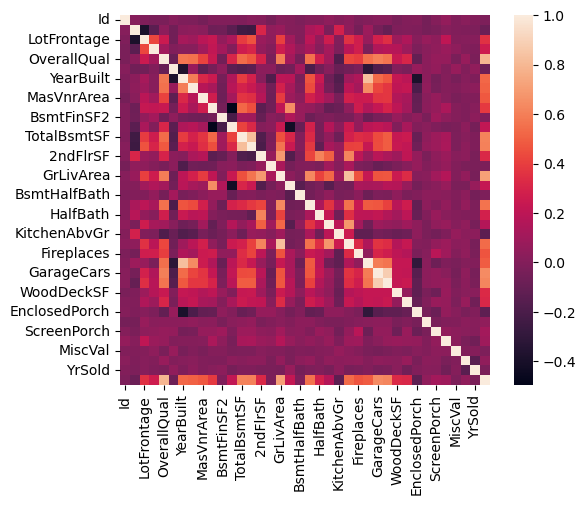

In [68]:
corr_matrix = train.corr()
f, ax = plt.subplots()
sns.heatmap(corr_matrix, vmax=1, square=True)

In [69]:
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum() / train.isnull().count()).sort_values(ascending=False)
null_table = pd.concat([total, percent], axis=1, keys=["total", "percent"])
null_table.loc[null_table["total"] > 0]

,total,percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


GarageX 변수들은 모두 동일한 null값을 가지고 있다. 해당 값들은 집에 지하실이 없을 경우 생성한 값으로 추측할 수 있다.

PoolQC, MiscFeature, Alley, Fence는 너무 많은 null값을 가지고 있어 연관되는 특성(PoolArea)과 함께 삭제한다.

In [70]:
too_many_na = []
for col in train.columns:
    if (train[col].isna().sum() > len(train) * 0.7):
        too_many_na.append(col)
        train = train.drop(col, axis='columns')
print(too_many_na)
train = train.drop('PoolArea', axis='columns')

['Alley', 'PoolQC', 'Fence', 'MiscFeature']


In [77]:
train = train.drop("Id", axis="columns")

이상치 제거 Z-score를 구해서 3이상인 데이터들을 모두 삭제

In [76]:
z_score = (train["SalePrice"] - train["SalePrice"].mean()) / train["SalePrice"].std()
print(len(train))
train = train[z_score.abs().sort_values() < 3]
print(len(train))

1460
1438


C:\Users\D568\AppData\Local\Temp\ipykernel_22304\715068100.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train = train[z_score.abs().sort_values() < 3]


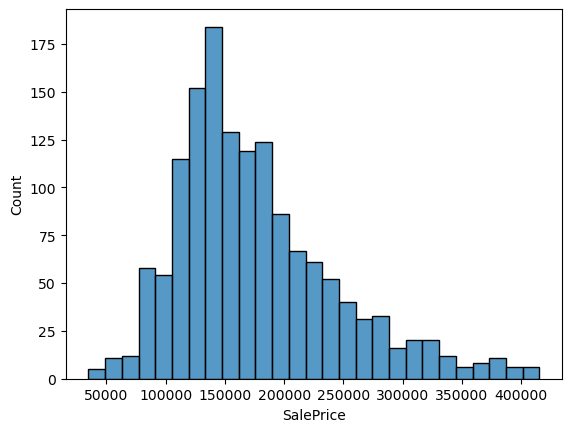

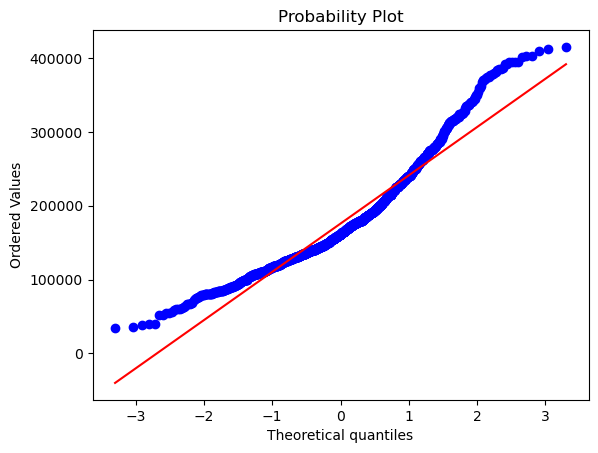

In [79]:
from scipy.stats import norm, probplot


sns.histplot(train['SalePrice'])
fig = plt.figure()
res = probplot(train['SalePrice'], plot=plt)

C:\Users\D568\AppData\Local\Temp\ipykernel_22304\3655469966.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test)


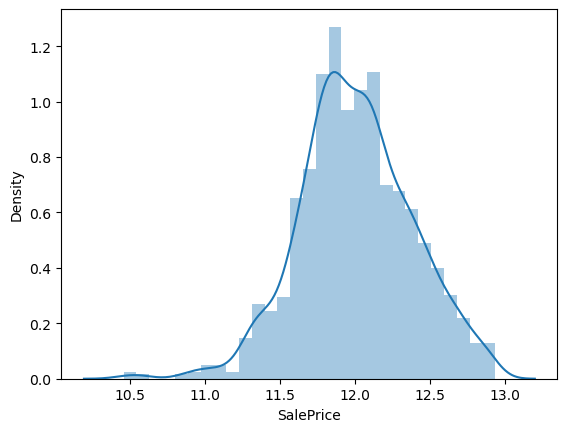

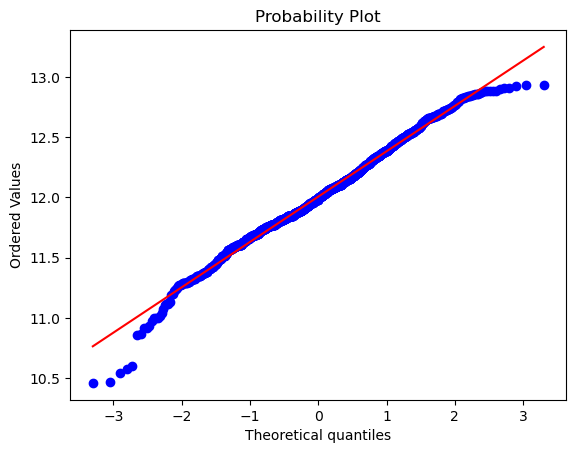

In [81]:
test = np.log(train['SalePrice'])
sns.distplot(test)
fig = plt.figure()
res = probplot(test, plot=plt)

In [82]:
object_columns = []
for col in train.columns:
    if (train[col].dtype == 'object'):
        object_columns.append(col)
print(object_columns)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


In [83]:
dummy_train = pd.get_dummies(train, columns=object_columns)

In [130]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

In [95]:
X = dummy_train.loc[:, dummy_train.columns != 'SalePrice']
y = dummy_train['SalePrice']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

In [96]:
log_reg = LogisticRegression()
forest = RandomForestRegressor(n_estimators=100, n_jobs=-1)
forest.fit(X_train.fillna(0), y_train)

RandomForestRegressor(n_jobs=-1)

In [99]:
y_pred = forest.predict(X_valid.fillna(0))

(432, 2)

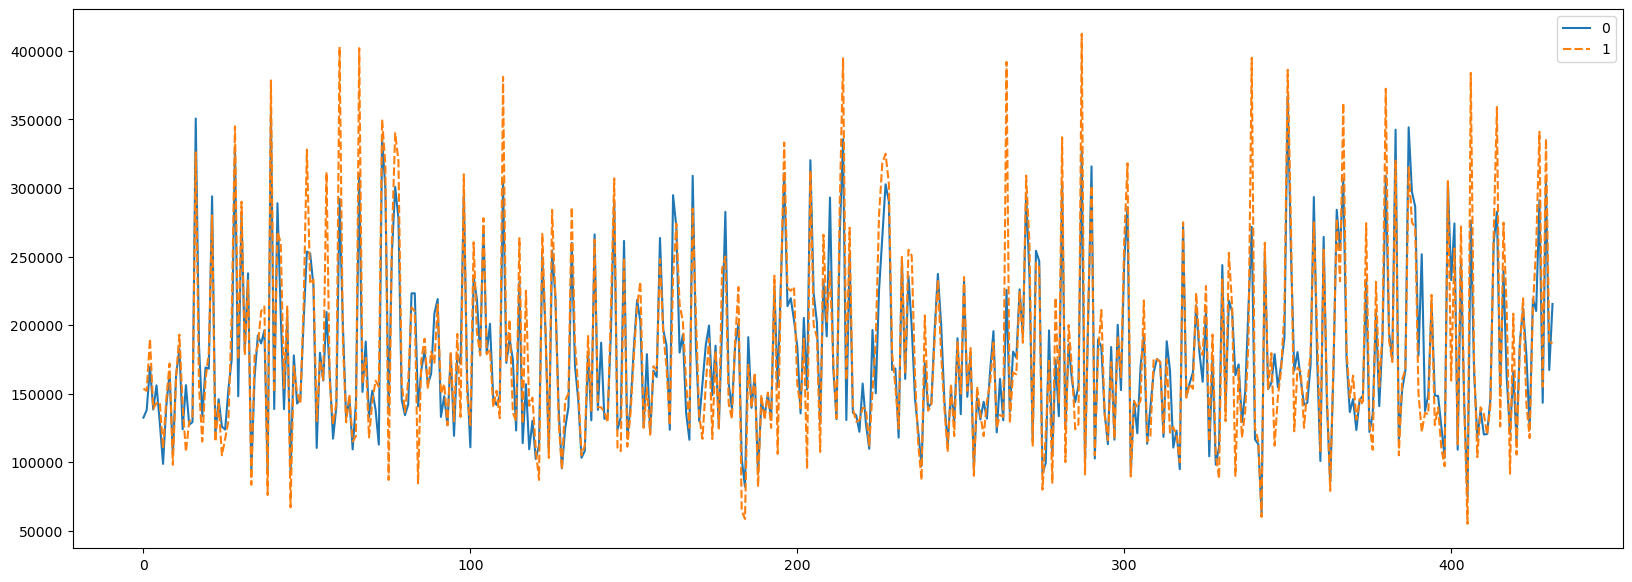

In [129]:
fig, ax = plt.subplots(figsize=(20, 7))
fig = sns.lineplot(np.stack([y_pred, y_valid], axis=1))

In [105]:
mean_squared_error(y_pred=y_pred, y_true=y_valid)

718755947.5131546